<table style="width: 100%;"> <tr> <td style="width: 20%; vertical-align: top;"> <img src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" alt="UdeA" height="150px"> </td> <td style="width: 80%; padding-left: 20px;"> <strong style="font-size: 30px;">MODELO DE REDES NEURONALES CONVOLUCIONALES PARA UN SISTEMA DE CLASIFICACIÓN CON IMÁGENES DE RESONANCIA MAGNÉTICA </strong><br><br> <span style="font-size: 30px;"> Luisa Fernanda Alzate Cuartas <br> Juan Camilo Henao Caro<br>Isabella Mendez Hoyos<br> Fernando Antonio Piñeres Ramos </span> </td> </tr> </table>

#### IMPORTE E INSTALACIÓN DE LIBRERÍAS

In [ ]:
# Conectar con Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Instalación de librerías.
!pip install optuna #Para optimizar hiperparámetros de modelos de aprendizaje automático y otros modelos.

In [ ]:
import sys #Interactuar de manera directa con el intérprete de Python
import os #Se utiliza para interactuar con el sistema operativo
path = '/content/drive/MyDrive/operaciones' # Configura el entorno para trabajar con archivos en Google Drive
sys.path.append(path) # Permite importar módulos desde esta ruta.
os.chdir(path) # Cambia el directorio de trabajo actual

In [ ]:
!ls /content/drive/MyDrive/operaciones/

a_preprocesamiento.ipynb  data		operaciones  README.md
b_modelo.ipynb		  funciones.py	__pycache__  salidas


In [ ]:
# Importe de librerías.
import optuna #Para el ajuste de hiperparámetros.
import numpy as np  #Manipulación de estructuras de datos matriciales y funciones matemáticas de alto nivel.
import pandas as pd #Manipulación y transformación de datos.
import tensorflow as tf # Permite crear y entrenar redes neuronales, procesar datos y gestionar modelos para diversas aplicaciones.
from sklearn import metrics #. Funciones de puntuación, métricas de rendimiento, métricas por pares y cálculos de distancia.
from sklearn.metrics import roc_auc_score #Calcular el área bajo la curva característica operativa del receptor (ROC AUC) a partir de los puntajes de predicción.
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Permite expandir los datos de entrenamiento de la imagen, mediante el uso de transformaciones como rotaciones aleatorias, transformaciones de corte, cambios, zooms y giros, en los datos de imagen disponibles.
from tensorflow.keras.models import Sequential #Apropiado para una pila simple de capas donde cada capa tiene exactamente un tensor de entrada y un tensor de salida .
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization #Para construir una red neuronal convolucional compleja que pueda procesar y aprender de datos de imágenes, textos secuenciales, o cualquier otro dato que pueda ser representado en una cuadrícula 2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint ### Importación de Callbacks para el Control del Entrenamiento
#Los Callbacks son herramientas poderosas que nos permiten monitorear y controlar el proceso de entrenamiento del modelo, ayudando a optimizar el rendimiento y la eficiencia.
from sklearn.utils import shuffle #´Para que el modelo no aprenda de un orden específico y para asegurar que el entrenamiento sea más robusto.
import joblib #Para guardar y cargar modelos de machine learning.
#Guardar el modelo una vez entrenado para no tener que entrenarlo de nuevo cada vez que lo necesites usar.
import random
from tensorflow.keras.utils import to_categorical
from funciones import balance_datasets, make_gradcam_heatmap, superimpose_heatmap, show_images_with_gradcam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras import layers, regularizers, Input, Model
import seaborn as sns

#### LECTURA DEL CONJUNTO DE IMÁGENES

In [ ]:
#Cargar el conjunto de datos(imágenes) a usar para el modelo.
x_train = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/x_train.pkl') # Datos(imágenes) para el entrenamiento del modelo.
y_train = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/y_train.pkl') # Etiquetas para el entrenamiento del modelo.
x_test = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/x_test.pkl') # Datos(imágenes) para la validación del modelo.
y_test = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/y_test.pkl') # Etiquetas para el testeo del modelo.
x_val = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/x_val.pkl') # Datos(imágenes) para la validación del modelo.
y_val = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/y_val.pkl') # Etiquetas para la validación del modelo.

#### EXPLORACIÓN DEL CONJUNTO DE DATOS(IMÁGENES)

In [ ]:
#Verificación de las Dimensiones de los Datos
display(x_train.shape)
display(y_train.shape)
display(x_test.shape)
display(y_test.shape)
display(x_val.shape)
display(y_val.shape)

(5553, 160, 160, 3)

(5553,)

(695, 160, 160, 3)

(695,)

(694, 160, 160, 3)

(694,)

`Esto nos asegura que las imágenes y sus etiquetas tienen el formato correcto para el modelo.`

In [ ]:
#Cantidad de clases por conjunto.
x_train.shape
x_test.shape
x_val.shape

display(np.unique(y_train, return_counts=True)) # Conteo de las clases para el conjunto de datos(imágenes) para entrenamiento.
display(np.unique(y_test, return_counts=True)) #Conteo de clases para el conjunto de datos(imáganes) para testeo.
display(np.unique(y_val, return_counts=True)) #Conteo de clases para el conjunto de datos(imágenes) para validación, despliegue.

(array([0, 1, 2, 3]), array([1232, 1316, 1600, 1405]))

(array([0, 1, 2, 3]), array([154, 165, 200, 176]))

(array([0, 1, 2, 3]), array([154, 164, 200, 176]))

`De acuerdo a lo resultados anteriores, este es un problema de clasificación multiclase y aunque las clases no parecen muy desbalanceadas, para prevenir el sobreajuste y mejorar la robustez del modelo, hemos decido utilizar una técnica llamada aumentación de datos.`

#### PREPARACIÓN DE LOS DATOS PARA EL ENTRENAMIENTO.

##### PREPROCESAMIENTO:NORMALIZACIÓN DE LOS PÍXELES.

`Las imágenes suelen tener valores de píxel en el rango de 0 a 255, por lo tanto es necesario escalarlos para que queden en un rango de 0 a 1, optimizando el rendimiento y la estabilidad del entrenamiento de la red neuronal. `






```
# El proceso implica:
1.  Convertir el tipo de dato de los píxeles a `float32`.
2.  Dividir cada valor de píxel por el valor máximo posible (255).
```



In [ ]:
# Convertir el tipo de dato de los píxeles a float32.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')

# Verificación de el nuevo rango de valores de píxeles después de normalizar.
print(f"x_train: Min={x_train.min()}, Max={x_train.max()}")
print(f"x_test:  Min={x_test.min()}, Max={x_test.max()}")
print(f"x_val:   Min={x_val.min()}, Max={x_val.max()}")

x_train: Min=0.0, Max=255.0
x_test:  Min=0.0, Max=255.0
x_val:   Min=0.0, Max=255.0


In [ ]:
# Escalar los valores de los píxeles al rango [0, 1].
x_train /= 255
x_test /= 255
x_val /= 255

# Verificación de el nuevo rango de valores de píxeles después de normalizar.
print(f"x_train: Min={x_train.min()}, Max={x_train.max()}")
print(f"x_test:  Min={x_test.min()}, Max={x_test.max()}")
print(f"x_val:   Min={x_val.min()}, Max={x_val.max()}")

x_train: Min=0.0, Max=1.0
x_test:  Min=0.0, Max=1.0
x_val:   Min=0.0, Max=1.0


`Las imágenes se cargaron con valores de píxel en el rango estándar de 0 a 255. Sin embargo, al normalizarlas (dividir por 255), se observó que el valor de píxel más alto presente en todos los conjuntos de datos era 1. Esto resultó en un rango normalizado de 0.0 a 0.00392(1/255). Esta característica es común en imágenes médicas, donde la información relevante a menudo se concentra en un rango de intensidad muy bajo.`

##### AUMENTACIÓN DE DATOS (DATA AUGMENTATION).

`La Aumentación de Datos es una técnica que consiste en crear nuevas muestras de datos de entrenamiento modificando ligeramente las existentes. En el contexto de imágenes, esto significa aplicar transformaciones aleatorias (como rotaciones, zooms, volteos, cambios de brillo, etc.) a las imágenes originales para generar versiones "nuevas" que el modelo pueda aprender.`

`No estamos añadiendo datos reales y únicos, sino expandiendo artificialmente la diversidad de nuestro conjunto de entrenamiento a partir de las imágenes ya disponibles.Cada vez que el modelo accede a una imagen original durante el entrenamiento, se genera una versión ligeramente diferente de la misma. De esta manera, el modelo nunca ve la misma imagen idéntica dos veces, lo que fuerza a aprender patrones más generales en lugar de memorizar ejemplos específicos.`

In [ ]:
# Generador de augmentación
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest' #se rellena los pixeles vacios con el pixel mas cercano
)

In [ ]:
# Aumentar el conjunto de entrenamiento.
x_train_balanced, y_train_balanced = balance_datasets(x_train, y_train, datagen)

`Aplicamos aumentación de datos únicamente al conjunto de entrenamiento, y mantenemos los datos de validación y prueba "originales" para evaluar al modelo.`

In [ ]:
# Guardar los conjuntos balanceados.
joblib.dump(x_train_balanced, '/content/drive/MyDrive/operaciones/salidas/data_final/x_train_balanced.pkl')
joblib.dump(y_train_balanced, '/content/drive/MyDrive/operaciones/salidas/data_final/y_train_balanced.pkl')

['/content/drive/MyDrive/operaciones/salidas/data_final/y_train_balanced.pkl']

In [ ]:
#Dimensiones de los datos(imágenes) balanceados.
display(x_train_balanced.shape,x_val.shape, x_test.shape)


(6400, 160, 160, 3)

(694, 160, 160, 3)

(695, 160, 160, 3)

`Después de aplicada la aumentación de datos, para el entrenamiento contamos con 6400 en total, es decir, 1600 imágenes por categoría: Glioma, Meningioma, Notumos y pituitary.`

##### ONE-HOT ENCODING

`Cuando trabajamos con redes neuronales para clasificar imágenes(tumores), las etiquetas que usamos para representar las categorías(0,1,2,3) tiene un problema, los números implican orden para la computadora y la intepretación no es correcta, los tipos de tumor y no tumor son categorías distintas. El One-Hot Encoding resuelve este problema transformando cada categoría en un vector multiclase. `

In [ ]:
#Visualización de la forma de los datos categoricos.
display(y_train_balanced.shape,y_test.shape,y_val.shape)
display(y_train_balanced,y_test,y_val)


(6400,)

(695,)

(694,)

array([1, 1, 2, ..., 3, 3, 0])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
#Trasnformación a vectore multiclase.
num_classes = 4

y_train_one_hot = to_categorical(y_train_balanced, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

In [ ]:
# Guardar las matrices multiclase de las categorías
joblib.dump(y_train_one_hot, '/content/drive/MyDrive/operaciones/salidas/data_final/y_train_one_hot.pkl')
joblib.dump(y_val_one_hot, '/content/drive/MyDrive/operaciones/salidas/data_final/y_val_one_hot.pkl')
joblib.dump(y_test_one_hot, '/content/drive/MyDrive/operaciones/salidas/data_final/y_test_one_hot.pkl')

['/content/drive/MyDrive/operaciones/salidas/data_final/y_test_one_hot.pkl']

In [ ]:
#Visualización de la forma del conjunto de datos categoricos.
display(y_train_one_hot.shape,y_test_one_hot.shape,y_val_one_hot.shape)
display(y_train_one_hot, y_val_one_hot,y_test_one_hot)

(6400, 4)

(695, 4)

(694, 4)

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

`Cada etiqueta numérica original (0, 1, 2, 3) ha sido transformada en un vector multiclase de 4 elementos (correspondiente a las 4 clases de tumores).`

#### MODELOS DE REDES NEURONALES CONVOLUSIONALES

##### MODELO BASE
---

In [ ]:
#Modelo base de redes neuronales convolucionales.

#Semilla para garantizar la reproducibilidad de los resultados.
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

#Relu introduce no-linealidad en el modelo, lo que le permite aprender relaciones más complejas en los datos.
inputs = tf.keras.Input(shape=x_train_balanced.shape[1:]) #Capa de entrada.
#Capas convolucionales.
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(inputs) #Utiliza 16 filtros de tamaño 3x3. Esto significa que aprenderá a detectar 16 tipos diferentes de características básicas.
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x) # Estas capas se utilizan para reducir la dimensionalidad de los mapas de características generados por las capas convolucionales
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='last_conv')(x) # Utiliza 32 filtros de tamaño 3x3, combina las características de la capa anterior identificar patrones más complejos.
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x) # Capa de Aplanamiento, convierte esta representación en un vector unidimensional largo.
x = tf.keras.layers.Dense(64, activation='relu')(x) #aprenden a combinar las  características detectadas para hacer una predicción final.
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

cnn_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
#Compilación de la red neuronal base.
cnn_model.compile(
    loss='categorical_crossentropy',# es la función de pérdida estándar y más apropiada para problemas de clasificación multiclase
    optimizer='adam', #optimizadores más populares y robustos en el campo del Deep Learning
    metrics=['AUC'] #Área Bajo la Curva ROC) es una métrica muy valiosa, especialmente en problemas de clasificación
    #Mide la capacidad de un clasificador para distinguir entre las diferentes clases
    #valor de AUC cercano a 1.0 indica un excelente rendimiento del modelo, mientras que un valor de 0.5 sugiere que el modelo clasifica al azar
)
cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 158, 158, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 77, 77, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,957,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,962,724 (11.30 MB)

 Trainable params: 2,962,724 (11.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Permite detener el entrenamiento si las métricas desmejoran.
early_stopping = EarlyStopping( #Define la regla de parada temprana que detiene el entrenamiento si el valor de las métricas de los datos de validación no mejoran durante 2 épocas.
    monitor='val_AUC',
    patience=2,
    mode='max',
    restore_best_weights=True
)

#Almacena los resultados en un archivo .keras
model_checkpoint = ModelCheckpoint(
    filepath='operaciones/salidas/best_model/modelo_base.keras',
    monitor='val_AUC',
    mode='max',
    save_best_only=True,
    verbose=1
)

#Entrenamiento del modelo
history = cnn_model.fit(
    x_train_balanced, y_train_one_hot,
    validation_data=(x_test, y_test_one_hot),
    epochs=15,
    callbacks=[early_stopping, model_checkpoint],
    batch_size=100
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.7817 - loss: 1.0646
Epoch 1: val_AUC improved from -inf to 0.95709, saving model to operaciones/salidas/best_model/modelo_base.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - AUC: 0.7833 - loss: 1.0605 - val_AUC: 0.9571 - val_loss: 0.4914
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9650 - loss: 0.4461
Epoch 2: val_AUC improved from 0.95709 to 0.97328, saving model to operaciones/salidas/best_model/modelo_base.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - AUC: 0.9651 - loss: 0.4457 - val_AUC: 0.9733 - val_loss: 0.3756
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9813 - loss: 0.3239
Epoch 3: val_AUC improved from 0.97328 to 0.97660, saving model to operaciones/salidas/best_model/modelo_base.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - AUC: 0.9814 - loss: 0.3237 - val_AUC: 0.9766 - val_loss: 0.3491
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9923 - loss: 0.2125
Epoch 4: val_AUC improved

In [ ]:
#Gráfica de la función de perdida para el conjunto de entrenamiento y testeo.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Variación de la función de pérdida para el modelo base')
plt.ylabel('Loss')
plt.xlabel('Epoch - entrenamiento')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
 #valor de AUC cercano a 1.0 indica un excelente rendimiento del modelo, mientras que un valor de 0.5 sugiere que el modelo clasifica al azar

NameError: name 'history' is not defined

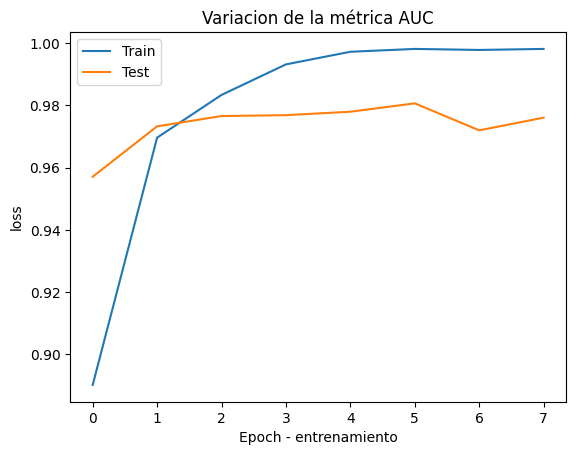

In [ ]:
#Gráfica del AUC para el conjunto de entrenamiento y testeo.
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Variacion de la métrica AUC para el modelo base')
plt.ylabel('loss')
plt.xlabel('Epoch - entrenamiento')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
 #valor de AUC cercano a 1.0 indica un excelente rendimiento del modelo, mientras que un valor de 0.5 sugiere que el modelo clasifica al azar

`Los resultados muestran que el modelo es capaz de aprender los patrones en los datos de entrenamiento de manera muy efectiva. Sin embargo, también evidencian que el modelo está sufriendo de sobreajuste.`

In [44]:
#Para el modelo base.
modelo_ganador=tf.keras.models.load_model('operaciones/salidas/best_model/modelo_base.keras')
test_loss, test_auc = modelo_ganador.evaluate(x_test, y_test_one_hot)
print(f"\Mejor AUC on test set: {test_auc:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 489ms/step - AUC: 0.9581 - loss: 0.4912
\Mejor AUC on test set: 0.9807


##### MODELO CNN CON REGULARIZACION L2
---

In [ ]:
#Modelo de redes convoluciones con regularización L2

#semilla
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

#Hiperparámetros
reg_strength = 0.001
dropout_rate = 0.1 #Proporción de neuronas que se apagan o desactivan durante el entrenamiento.
input_shape = x_train_balanced.shape[1:]

#Modelo.
inputs = tf.keras.Input(shape=input_shape) #Capa de entrada

x = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', #Detecta 16 patrones o características diferentes (bordes, texturas) en las imágenes utilizando filtros de 3x3.
                           kernel_regularizer=regularizers.l2(reg_strength))(inputs) #Añade una pequeña penalización a la función de pérdida del modelo
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x) #Reduce la dimensionalidad de los mapas de características a la mitad (en ancho y alto)
x = tf.keras.layers.Dropout(dropout_rate)(x) #"apaga" aleatoriamente un porcentaje de las neuronas de la capa actual

x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', #Aprende características de mayor nivel combinando las detectadas por la capa anterior
                           kernel_regularizer=regularizers.l2(reg_strength))(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

x = tf.keras.layers.Flatten()(x) #Convierte los mapas de características 2D (o 3D) de las capas convolucionales en un vector unidimensional
x = tf.keras.layers.Dense(64, activation='relu', #Aprende patrones complejos a partir de las características aplanadas
                          kernel_regularizer=regularizers.l2(reg_strength))(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

cnn_model2 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
#Compilación.
cnn_model2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[tf.keras.metrics.AUC(name='AUC')]
)

cnn_model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 158, 158, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 79, 79, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 79, 79, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 77, 77, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     2,957,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,962,724 (11.30 MB)

 Trainable params: 2,962,724 (11.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Permite detener el entrenamiento si las métricas desmejoran.
early_stopping = EarlyStopping(
    monitor='val_AUC',
    patience=2,
    mode='max',
    restore_best_weights=True
)



checkpoint2 = ModelCheckpoint(
    filepath='operaciones/salidas/best_model/modelo_regulacion.keras',
    monitor='val_AUC',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Entrenamiento
history2 = cnn_model2.fit(
    x_train_balanced, y_train_one_hot,
    batch_size=100,
    epochs=7,
    validation_data=(x_test, y_test_one_hot),
    callbacks=[checkpoint2,early_stopping]
)

Epoch 1/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - AUC: 0.7407 - loss: 1.3047
Epoch 1: val_AUC improved from -inf to 0.94173, saving model to operaciones/salidas/best_model/modelo_regulacion.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - AUC: 0.7425 - loss: 1.3007 - val_AUC: 0.9417 - val_loss: 0.7185
Epoch 2/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - AUC: 0.9361 - loss: 0.7257
Epoch 2: val_AUC improved from 0.94173 to 0.96861, saving model to operaciones/salidas/best_model/modelo_regulacion.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - AUC: 0.9363 - loss: 0.7250 - val_AUC: 0.9686 - val_loss: 0.5583
Epoch 3/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9596 - loss: 0.5957
Epoch 3: val_AUC improved from 0.96861 to 0.97661, saving model to operaciones/salidas/best_model/modelo_regulacion.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - AUC: 0.9596 - loss: 0.5954 - val_AUC: 0.9766 - val_loss: 0.4899
Epoch 4/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9727 - loss: 0.5146
Epoch 4: va

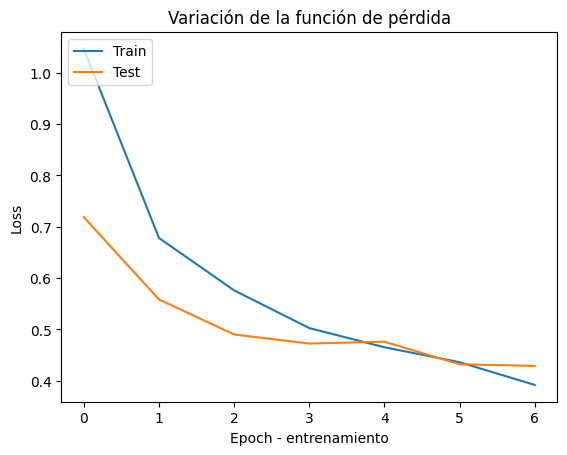

In [ ]:
##Gráfica de la función de perdida para el conjunto de entrenamiento y testeo.
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Variación de la función de pérdida para modelo de regulación L2')
plt.ylabel('Loss')
plt.xlabel('Epoch - entrenamiento')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


`La pérdida en el conjunto de entrenamiento (Train) sigue bajando, lo cual es bueno. Pero la pérdida en el conjunto de prueba (Test) deja de bajar e incluso empieza a subir ligeramente. Esto significa que el modelo está aprendiendo a memorizar los datos de entrenamiento, pero está perdiendo su capacidad para manejar datos nuevos.`

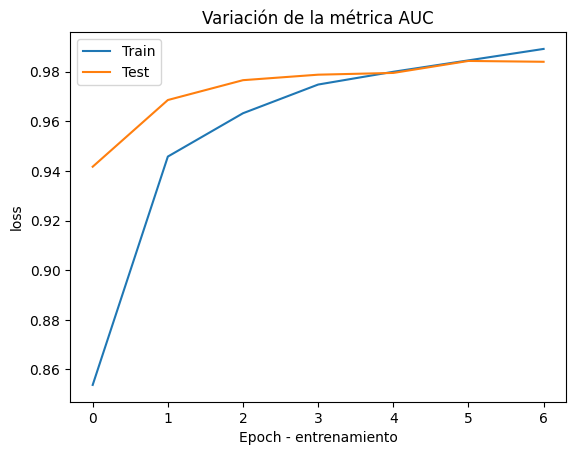

In [ ]:
##Gráfica de la métrica AUC para el conjunto de entrenamiento y testeo.
plt.plot(history2.history['AUC'])
plt.plot(history2.history['val_AUC'])
plt.title('Variación de la métrica AUC modelo de regularización L2')
plt.ylabel('loss')
plt.xlabel('Epoch - entrenamiento')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

`El AUC en entrenamiento sigue subiendo y es muy alto, pero el AUC en el conjunto de prueba se estanca o baja un poco después de las primeras épocas. Esto confirma que el modelo es muy bueno con lo que ya conoce, pero no tan bueno con lo desconocido.`

`Una alternativa de solución es entrenar el modelo con una cantidad de mayor de Epochs. `

In [43]:
#Para el modelo regularización.
modelo_ganador=tf.keras.models.load_model('operaciones/salidas/best_model/modelo_regulacion.keras')
test_loss, test_auc = modelo_ganador.evaluate(x_test, y_test_one_hot)
print(f"\Mejor AUC on test set: {test_auc:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 312ms/step - AUC: 0.9782 - loss: 0.4831
\Mejor AUC on test set: 0.9844


##### MODELOS LIGEROS: APLICADOS AL MODELO DE REDES NEURONALES CON REGULARIZACIÓN L2

`Considerando que el modelo con regularización L2 aún no es adecuado, se validará con aplicando modelos ligeros con más Epochs y ver su rendimiento.`



```
# Cambios realizados:

*   Reducción de filtros en las capas.
*   Uso de GlobalAveragePooling2D en lugar de Flatten, menos parámetros y menos overfitting.
*   Se reduce la regularización.

```



In [ ]:
# Semilla para reproducibilidad
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Parámetros para modelo ligero
reg_strength = 0.0001
dropout_rate = 0.05
input_shape = (160, 160, 3)

inputs = Input(shape=input_shape)

# Bloque 1 - pocos filtros, kernel pequeño
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(reg_strength))(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(dropout_rate)(x)

# Bloque 2 - más filtros pero moderado
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(reg_strength))(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(dropout_rate)(x)

# Aplanar y capa densa pequeña
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(reg_strength))(x)
x = layers.Dropout(dropout_rate)(x)

# Salida para 4 clases
outputs = layers.Dense(4, activation='softmax')(x)

cnn_model_light = Model(inputs=inputs, outputs=outputs)

cnn_model_light.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 160, 160, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 80, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40, 40, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,638,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,640,116 (6.26 MB)

 Trainable params: 1,640,116 (6.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

#compilación
cnn_model_light.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['AUC']
)

In [ ]:
#Control en el entrenamiento.
early_stopping = EarlyStopping(
    monitor='val_AUC',
    patience=2,
    mode='max',
    restore_best_weights=True
)


checkpoint = ModelCheckpoint(
    filepath= 'operaciones/salidas/best_model/modelo_liviano.keras',
    monitor='val_AUC',
    mode='max',
    save_best_only=True,
    verbose=1
)

#Entrenamiento
history3 = cnn_model_light.fit(
     x_train_balanced, y_train_one_hot,
    validation_data=(x_test, y_test_one_hot),
     epochs=15,
     batch_size=100,
   callbacks=[checkpoint, early_stopping]
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.8221 - loss: 0.9799
Epoch 1: val_AUC improved from -inf to 0.96213, saving model to operaciones/salidas/best_model/modelo_liviano.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - AUC: 0.8233 - loss: 0.9766 - val_AUC: 0.9621 - val_loss: 0.4852
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9609 - loss: 0.4891
Epoch 2: val_AUC improved from 0.96213 to 0.97626, saving model to operaciones/salidas/best_model/modelo_liviano.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - AUC: 0.9610 - loss: 0.4886 - val_AUC: 0.9763 - val_loss: 0.3851
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9771 - loss: 0.3848
Epoch 3: val_AUC improved from 0.97626 to 0.98082, saving model to operaciones/salidas/best_model/modelo_liviano.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - AUC: 0.9771 - loss: 0.3846 - val_AUC: 0.9808 - val_loss: 0.3522
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9863 - loss: 0.3080
Epoch 4: val_AUC

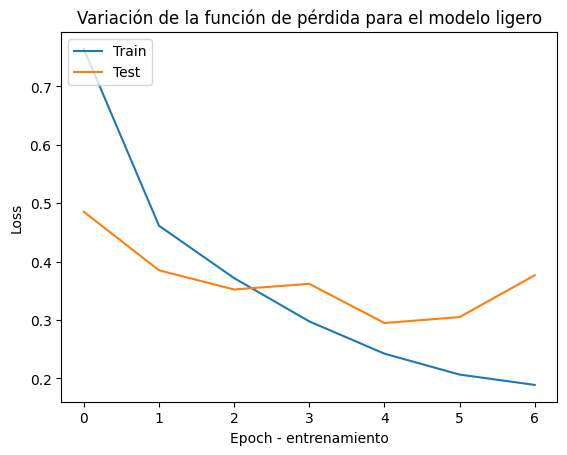

In [ ]:
##Gráfica de la función de perdida para el conjunto de entrenamiento y testeo.
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Variación de la función de pérdida para el modelo ligero')
plt.ylabel('Loss')
plt.xlabel('Epoch - entrenamiento')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

`Durante las primeras épocas (aproximadamente hasta la época 3-4), la función de pérdida disminuye de manera consistente tanto para el conjunto de entrenamiento como para el conjunto de prueba. Sin embargo, a partir de la época 3-4, mientras que la pérdida de entrenamiento continúa su descenso, la pérdida del conjunto de prueba deja de disminuir.Aún se manifiesta el sobre ajuste. `

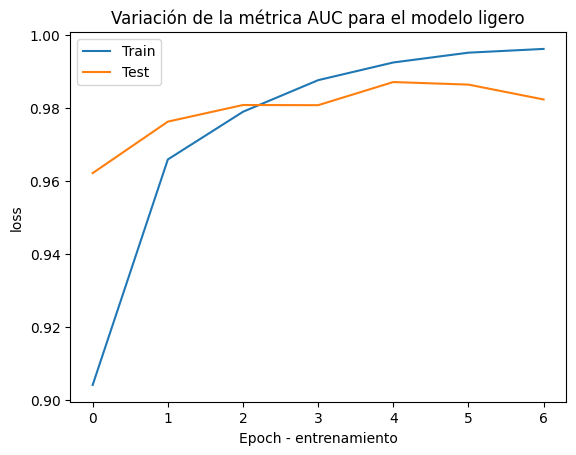

In [ ]:
##Gráfica de la métrica AUC para el conjunto de entrenamiento y testeo.
plt.plot(history3.history['AUC'])
plt.plot(history3.history['val_AUC'])
plt.title('Variación de la métrica AUC para el modelo ligero')
plt.ylabel('loss')
plt.xlabel('Epoch - entrenamiento')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

`Al inicio del entrenamiento, el valor de AUC aumenta rápidamente y alcanza niveles muy altos, tanto en el conjunto de entrenamiento como en el de prueba, indicando que está distinguiendo las caracteristicas de los diferentes tumores y no tumor. Sin embargo, el conjunto de prueba tiende a estancarse o muestra ligeras fluctuaciones después de alcanzar su pico inicial. Esto refuerza el diagnóstico de sobreajuste, ya que la mejora en el rendimiento del modelo en datos no vistos se detiene.`

In [42]:
#Para el modelo liviano.
modelo_ganador=tf.keras.models.load_model('operaciones/salidas/best_model/modelo_liviano.keras')
test_loss, test_auc = modelo_ganador.evaluate(x_test, y_test_one_hot)
print(f"\Mejor AUC on test set: {test_auc:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - AUC: 0.9837 - loss: 0.3325
\Mejor AUC on test set: 0.9871


#### MODELO CON AJUSTES DE HIPERPARAMETROS
---

In [ ]:
# Función objetivo para utilizar Optuna con API funcional
def objective(trial):
    # Hiperparámetros
    dropout_rate = trial.suggest_float('dropout_rate', 0.05, 0.2, step=0.05)
    reg_strength = trial.suggest_float('reg_strength', 0.0001, 0.0005, step=0.0001)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd'])

    # Modelo funcional CNN
    inputs = tf.keras.Input(shape=x_train_balanced.shape[1:])
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_strength))(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_strength),
                               name='last_conv')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(reg_strength))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Optimizador
    opt = tf.keras.optimizers.Adam(learning_rate=0.001) if optimizer_name == 'adam' else tf.keras.optimizers.SGD(learning_rate=0.001)

    # Compilar
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=[tf.keras.metrics.AUC(name='auc')])

    # Callback

    early_stopping = EarlyStopping(
    monitor='val_AUC',
    patience=3,
    mode='max',
    restore_best_weights=True
)


    checkpoint3 = ModelCheckpoint(
        filepath='operaciones/salidas/best_model/modelo_hiperparametros.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    # Entrenamiento
    history4 = model.fit(
        x_train_balanced, y_train_one_hot,
        epochs=10,
        validation_data=(x_test, y_test_one_hot),
        batch_size=100,
        verbose=0,
        callbacks=[checkpoint3, early_stopping]
    )

    # Cargar mejor modelo
    model_win = tf.keras.models.load_model('operaciones/salidas/best_model/modelo_hiperparametros.keras')

    # Evaluación
    y_pred_prob = model_win.predict(x_test)
    auc = roc_auc_score(y_test_one_hot, y_pred_prob)
    trial.set_user_attr("model", model_win)

    return auc

  # Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1)

# Get best model
best_trial = study.best_trial
best_model = best_trial.user_attrs["model"]

# Final evaluation
test_loss, test_auc = best_model.evaluate(x_test, y_test_one_hot)
print(f"\Mejor AUC on test set: {test_auc:.4f}")
best_model.summary()


[I 2025-06-08 23:35:40,538] A new study created in memory with name: no-name-243ef3e6-7316-4f7b-b54d-081c14044569



Epoch 1: val_auc improved from -inf to 0.67787, saving model to operaciones/salidas/best_model/modelo_hiperparametros.keras

Epoch 2: val_auc improved from 0.67787 to 0.72231, saving model to operaciones/salidas/best_model/modelo_hiperparametros.keras

Epoch 3: val_auc improved from 0.72231 to 0.75313, saving model to operaciones/salidas/best_model/modelo_hiperparametros.keras

Epoch 4: val_auc improved from 0.75313 to 0.77733, saving model to operaciones/salidas/best_model/modelo_hiperparametros.keras

Epoch 5: val_auc improved from 0.77733 to 0.79620, saving model to operaciones/salidas/best_model/modelo_hiperparametros.keras

Epoch 6: val_auc improved from 0.79620 to 0.81069, saving model to operaciones/salidas/best_model/modelo_hiperparametros.keras

Epoch 7: val_auc improved from 0.81069 to 0.82220, saving model to operaciones/salidas/best_model/modelo_hiperparametros.keras

Epoch 8: val_auc improved from 0.82220 to 0.83404, saving model to operaciones/salidas/best_model/modelo_h

[I 2025-06-09 00:02:38,335] Trial 0 finished with value: 0.8472508764045473 and parameters: {'dropout_rate': 0.2, 'reg_strength': 0.0001, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.8472508764045473.


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - auc: 0.8016 - loss: 1.1117
\Mejor AUC on test set: 0.8542


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 158, 158, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 79, 79, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 79, 79, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 77, 77, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     2,957,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,962,726 (11.30 MB)

 Trainable params: 2,962,724 (11.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

#### XAI
---

`Este bloque de código implementa Grad-CAM, una técnica de Inteligencia Artificial Explicable (XAI) que genera un mapa de calor para mostrar las zonas de una imagen que más influyen en la predicción de una red neuronal convolucional. Al superponer este mapa sobre la imagen original, se obtiene una explicación visual útil para interpretar decisiones del modelo, especialmente en aplicaciones sensibles como el diagnóstico médico.`







In [ ]:
# Definir las clases que tienes
class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Función para generar Grad-CAM (supongo que ya la tienes, si no puedo ayudarte a armarla)
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Función para superponer heatmap a la imagen
def superimpose_heatmap(img, heatmap, alpha=0.4):
    import cv2
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    return superimposed_img

# Ejemplo para mostrar imágenes y predicciones con Grad-CAM
def show_images_with_gradcam(model, dataset, start_idx, end_idx, last_conv_layer_name):
    for i in range(start_idx, end_idx):
        img = dataset[i]
        img_array = np.expand_dims(img, axis=0)  # Expandir dims para batch
        preds = model.predict(img_array)
        pred_class = np.argmax(preds[0])
        pred_label = class_names[pred_class]

        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_class)
        img_uint8 = (img * 255).astype(np.uint8)  # Si tu imagen está en [0,1]
        superimposed_img = superimpose_heatmap(img_uint8, heatmap)

        plt.figure(figsize=(10,4))

        plt.subplot(1, 3, 1)
        plt.title('Imagen Original')
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Heatmap Grad-CAM')
        plt.imshow(heatmap, cmap='jet')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title(f'Imagen + Heatmap\nPredicción: {pred_label}')
        plt.imshow(superimposed_img)
        plt.axis('off')

        plt.show()

# Usar la función (por ejemplo para imágenes de índice 8 a 12)
show_images_with_gradcam(best_model, x_test, 80, 95, last_conv_layer_name='conv2d_3')


Output hidden; open in https://colab.research.google.com to view.

#### SELECCIÓN DEL MODELO GANADOR
---


In [ ]:
#Para el modelo de hiperparámetros.
modelo_ganador=tf.keras.models.load_model('operaciones/salidas/best_model/modelo_hiperparametros.keras')
test_loss, test_auc = modelo_ganador.evaluate(x_test, y_test_one_hot)
print(f"\Mejor AUC on test set: {test_auc:.4f}")



22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - auc: 0.8016 - loss: 1.1117
\Mejor AUC on test set: 0.8542


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step


Text(0.5, 1.0, 'probabilidades imágenes en entrenamiento')

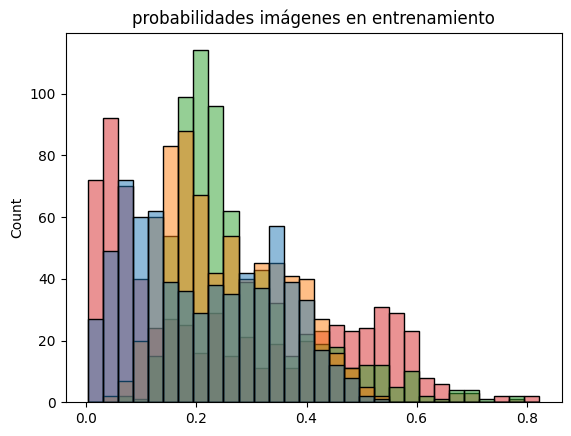

In [ ]:
#Probabilidades para cada tipo de clases.
prob=modelo_ganador.predict(x_test)
sns.histplot(prob, legend=False, bins=30)
plt.title("probabilidades imágenes en entrenamiento")


200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 201ms/step


Text(0.5, 1.0, 'probabilidades imágenes en entrenamiento')

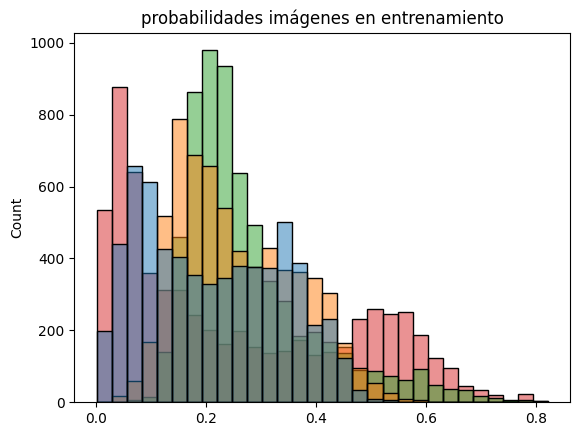

In [ ]:
### probabilidades en entrenamiento #####
prob=modelo_ganador.predict(x_train_balanced)
sns.histplot(prob, legend=False, bins=30)
plt.title("probabilidades imágenes en entrenamiento")### conocer el comportamiento de las probabilidades para revisar threshold


`El modelo tiene buena capacidad para distinguir entre clases (alto AUC), pero la alta pérdida y las bajas probabilidades sugieren que no está bien calibrado: acierta en las clasificaciones, pero sus probabilidades no reflejan bien su confianza.`

200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step
              precision    recall  f1-score   support

      glioma       0.62      0.45      0.52      1600
  meningioma       0.51      0.47      0.49      1600
     notumor       0.70      0.66      0.68      1600
   pituitary       0.62      0.87      0.72      1600

    accuracy                           0.61      6400
   macro avg       0.61      0.61      0.60      6400
weighted avg       0.61      0.61      0.60      6400

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step
              precision    recall  f1-score   support

      glioma       0.66      0.57      0.61       154
  meningioma       0.49      0.45      0.47       165
     notumor       0.82      0.67      0.73       200
   pituitary       0.63      0.88      0.73       176

    accuracy                           0.65       695
   macro avg       0.65      0.64      0.64       695
weighted avg       0.66      0.65      0.64       695



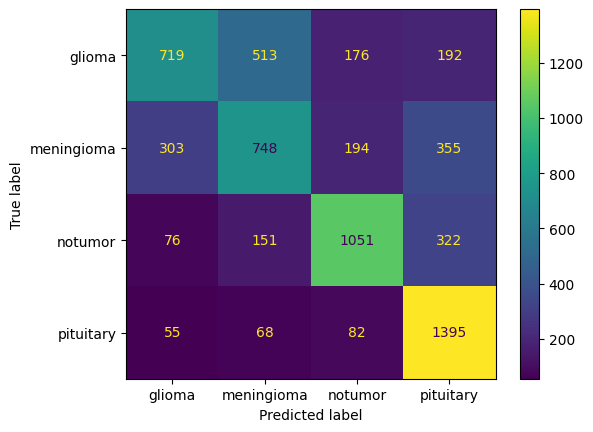

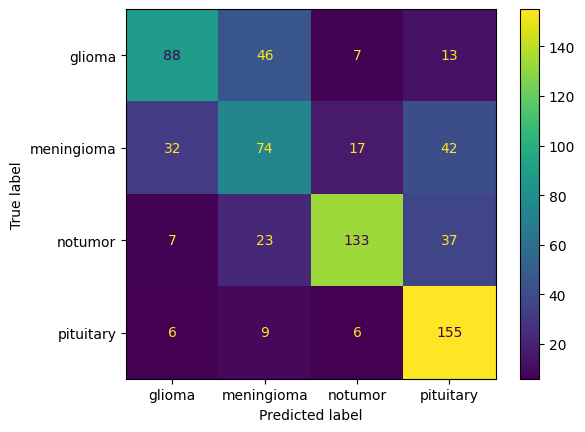

In [ ]:
import numpy as np
from sklearn import metrics

# --- TRAIN ---
# Obtener predicciones de clase (no usar threshold)
pred_train_prob = modelo_ganador.predict(x_train_balanced)
pred_train = np.argmax(pred_train_prob, axis=1)
y_train_true = np.argmax(y_train_one_hot, axis=1)  # si está one-hot encoded

# Reporte de métricas y matriz de confusión
print(metrics.classification_report(y_train_true, pred_train, target_names=['glioma', 'meningioma', 'notumor', 'pituitary']))
cm = metrics.confusion_matrix(y_train_true, pred_train, labels=[0, 1, 2, 3])
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=['glioma', 'meningioma', 'notumor', 'pituitary'])
disp.plot()

# --- TEST ---
pred_test_prob = modelo_ganador.predict(x_test)
pred_test = np.argmax(pred_test_prob, axis=1)
y_test_true = np.argmax(y_test_one_hot, axis=1)  # si está one-hot encoded

print(metrics.classification_report(y_test_true, pred_test, target_names=['glioma', 'meningioma', 'notumor', 'pituitary']))
cm = metrics.confusion_matrix(y_test_true, pred_test, labels=[0, 1, 2, 3])
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=['glioma', 'meningioma', 'notumor', 'pituitary'])
disp.plot()




```
# Clasificaciones correctas en entrenamiento (diagonal principal):


*   Glioma: 718 imágenes bien clasificadas.
*   Meningioma: 748 imágenes bien clasificadas.
*   Notumor: 1051 imágenes bien clasificadas.
*   Pituitary: 1395 imágenes bien clasificadas.

El modelo con hiperparámetros tiene un buen rendimiento global,
destacando su alta precisión en las clases notumor y pituitary.
Esto sugiere que logra identificar bien estas categorías,
probablemente porque sus características son más distintivas.

```










```
# Errores de Clasificación en entrenamiento:


*   Glioma: se confunde con:Meningioma (512), Notumor (176), Pituitary (182).
*   Meningioma: se confunde con:Glioma (303), Notumor (194), Pituitary (355).
*   Notumor: se confunde con:Pituitary (322), Meningioma (151).
*   Pituitary: se confunde con:Notumor (82), Meningioma (68).

Hay confusión frecuente entre clases de tumores (glioma vs meningioma) y entre notumor y pituitary,
lo que podría deberse a similitud visual en las imágenes o a características compartidas en los datos.
Esto evidencia la necesidad de mejorar la capacidad del modelo para diferenciar entre estas clases.
```



`El patrón de errores en el conjunto de prueba es consistente, lo que confirma que las debilidades del modelo no dependen del tamaño del conjunto de prueba. Esto refuerza la idea de que hay una necesidad estructural de mejorar la discriminación entre ciertas clases.`

#### CONCLUSIONES Y RECOMENDACIONES PARA EL MODELO CON AJUSTE DE HIPERPARÁMETROS.



```
Conclusiones.

1. El modelo tiene buen desempeño general, especialmente en las clases notumor y  pituitary.

2. Hay confusión importante entre glioma y meningioma, lo que indica
dificultad para diferenciar tumores con características similares.

3. También hay errores frecuentes entre notumor y pituitary,
lo que sugiere solapamiento de patrones visuales o ambigüedad en los datos.

4. Las confusiones se repiten en conjuntos grandes y pequeños,
lo que indica un problema estructural del modelo o los datos.

5. Se detectan posibles problemas de calibración: el modelo acierta
pero sus probabilidades no reflejan bien la confianza.

Recomendaciones.

1. Aumentar datos de entrenamiento en las clases más confusas (glioma, meningioma).

2. Revisar etiquetas y asegurar que los datos estén correctamente clasificados,
 especialmente en clases con muchas confusiones.

3. Aplicar técnicas de calibración de probabilidad (Platt Scaling, Isotonic Regression).

4.Probar modelos más avanzados que pueden captar mejor los patrones.

5. Evaluar el modelo con menos clases.

6. Verificación de la fuente de datos, no estamos seguros que las imágenes sean correctas como se encontraron clasificadas.
```

